# NERC task

In [2]:
import pandas as pd
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## CRF Model for NERC

## Loading the data

In [3]:
train_data = pd.read_csv("data/Training_data/ner_dataset.csv", encoding="latin1")
test_data = pd.read_csv("/Users/bogdankryvenko/Desktop/TM_NERC_PART/vrije-project-TM/data/NER-test.tsv", sep="\t", encoding="latin1")

## Preprocessing the train data

In [4]:
train_data = train_data.ffill()

transformed_train_data = train_data.drop('POS', axis=1)

## Preprocessing the test data

In [5]:
transformed_test_data = pd.DataFrame(columns=["Sentence #", "Word", "Tag"])

sentence_labels = []
current_sentence = None
    
for idx, row in test_data.iterrows():
    if row['sentence_id'] != current_sentence:
        sentence_labels.append(f"Sentence: {row['sentence_id'] + 1}")
        current_sentence = row['sentence_id']
    else:
        sentence_labels.append(f"Sentence: {row['sentence_id'] + 1}")
        
converted_test_labels = []

for label in test_data['BIO_NER_tag'].values:
    match label:
        case "O":
            converted_test_labels.append("O")
        case "B-PERSON":
            converted_test_labels.append("B-per")
        case "I-PERSON":
            converted_test_labels.append("I-per")
        case "B-ORG":
            converted_test_labels.append("B-org")
        case "I-ORG":
            converted_test_labels.append("I-org")
        case "B-LOCATION":
            converted_test_labels.append("B-geo")
        case "I-LOCATION":
            converted_test_labels.append("I-geo")
        case "B-WORK_OF_ART":
            converted_test_labels.append("B-art")
        case "I-WORK_OF_ART":
            converted_test_labels.append("I-art")
        case "B-ORG":
            converted_test_labels.append("B-org")
        case "I-ORG":
            converted_test_labels.append("I-org")
        
transformed_test_data['Sentence #'] = sentence_labels
transformed_test_data['Word'] = test_data['token']
transformed_test_data['Tag'] = converted_test_labels

In [6]:
transformed_test_data.head(20)

,Sentence #,Word,Tag
0,Sentence: 1,If,O
1,Sentence: 1,you're,O
2,Sentence: 1,visiting,O
3,Sentence: 1,Paris,B-geo
4,Sentence: 1,",",O
5,Sentence: 1,make,O
6,Sentence: 1,sure,O
7,Sentence: 1,to,O
8,Sentence: 1,see,O
9,Sentence: 1,the,O


## Checking the labels in the train and test data:

In [7]:
tag_counts_test = transformed_test_data['Tag'].value_counts()
tag_counts_train = transformed_train_data['Tag'].value_counts()
print("Test data tag counts:" , tag_counts_test)
print()
print("Train data tag counts:" , tag_counts_train)

Test data tag counts: Tag
O        159
I-per     13
B-per     12
B-org      8
I-art      8
B-art      6
I-org      5
B-geo      3
I-geo      2
Name: count, dtype: int64

Train data tag counts: Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64


## Creating a sentence getter class

In [8]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
train_sentences = SentenceGetter(transformed_train_data).sentences
test_sentences = SentenceGetter(transformed_test_data).sentences

/var/folders/7g/y23_f8fx7674ls2cfgh7r39m0000gn/T/ipykernel_10435/2851067360.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)
/var/folders/7g/y23_f8fx7674ls2cfgh7r39m0000gn/T/ipykernel_10435/2851067360.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence #").apply(agg_func)


## Creating features for the NERC task

In [10]:
def word2features(sent, i):
    word = sent[i][0]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(), 
        'word[-3:]': word[-3:], 
        'word[-2:]': word[-2:], 
        'word.isupper()': word.isupper(), 
        'word.istitle()': word.istitle(), 
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0] 
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True 

    if i < len(sent)-1:
        word1 = sent[i+1][0] 
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True 

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

## Creating the features for the train and test data

In [11]:
X_train = [sent2features(s) for s in train_sentences]
y_train = [sent2labels(s) for s in train_sentences]

X_test = [sent2features(s) for s in test_sentences]
y_test = [sent2labels(s) for s in test_sentences]

## Training a CRF model

In [12]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

## Evaluating the model on the train data

### With all labels

In [13]:
y_pred = crf.predict(X_test)
labels = list(crf.classes_)
# labels = list(set(transformed_test_data['Tag'].values.tolist()))
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print("Labels:", labels)
print("Train classification report:")
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

Labels: ['O', 'B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'I-tim', 'B-art', 'I-art', 'B-nat', 'I-gpe', 'I-nat', 'B-eve', 'I-eve']
Train classification report:
              precision    recall  f1-score   support

           O      0.891     0.975     0.931       159
       B-art      0.000     0.000     0.000         6
       I-art      0.000     0.000     0.000         8
       B-eve      0.000     0.000     0.000         0
       I-eve      0.000     0.000     0.000         0
       B-geo      0.429     1.000     0.600         3
       I-geo      0.667     1.000     0.800         2
       B-gpe      0.000     0.000     0.000         0
       I-gpe      0.000     0.000     0.000         0
       B-nat      0.000     0.000     0.000         0
       I-nat      0.000     0.000     0.000         0
       B-org      0.500     0.375     0.429         8
       I-org      0.500     0.600     0.545         5
       B-per      0.889     0.667     0.762        12
  

/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavio

### Without 'O' label

In [14]:
labels.remove('O')

# y_pred = crf.predict(X_test)
# metrics.flat_f1_score(y_test, y_pred, 
#                       average='weighted', labels=labels)
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-art      0.000     0.000     0.000         6
       I-art      0.000     0.000     0.000         8
       B-eve      0.000     0.000     0.000         0
       I-eve      0.000     0.000     0.000         0
       B-geo      0.429     1.000     0.600         3
       I-geo      0.667     1.000     0.800         2
       B-gpe      0.000     0.000     0.000         0
       I-gpe      0.000     0.000     0.000         0
       B-nat      0.000     0.000     0.000         0
       I-nat      0.000     0.000     0.000         0
       B-org      0.500     0.375     0.429         8
       I-org      0.500     0.600     0.545         5
       B-per      0.889     0.667     0.762        12
       I-per      1.000     0.538     0.700        13
       B-tim      0.000     0.000     0.000         0
       I-tim      0.000     0.000     0.000         0

   micro avg      0.619     0.456     0.525        57
   macro avg      0.249   

/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavio

## Visualizing the results

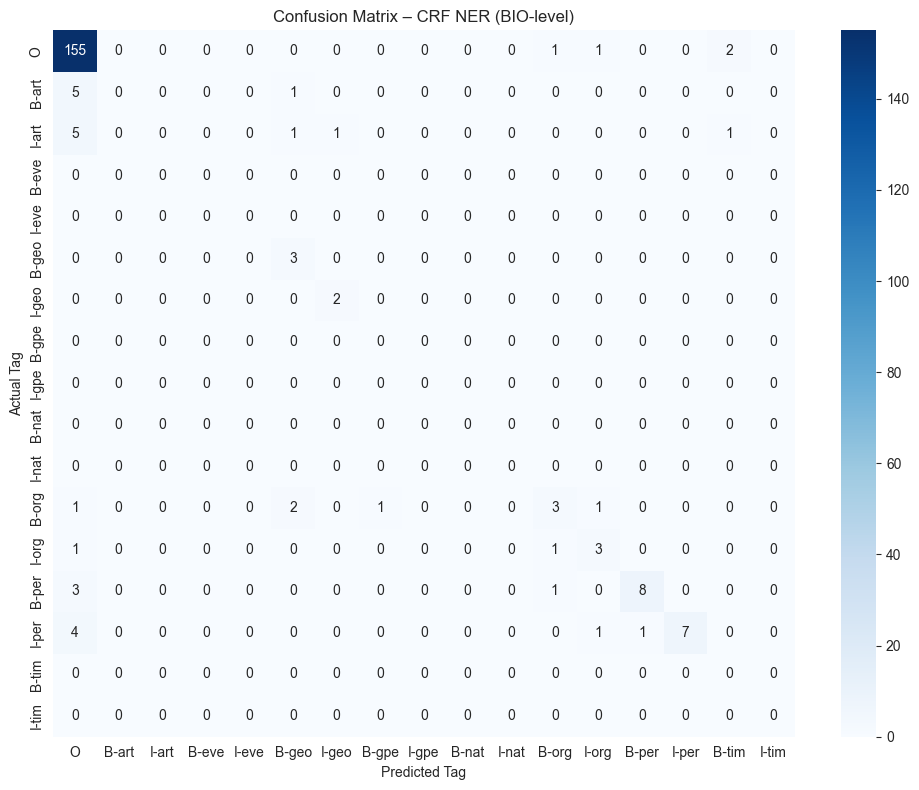

In [15]:
true_flat = []
crf_pred_flat = []
for sent in y_test:       
    for tag in sent:     
        true_flat.append(tag)

for sent in y_pred:       
    for tag in sent:      
        crf_pred_flat.append(tag)


sorted_labels = sorted(crf.classes_, key=lambda t: (t[2:], t[0]))

cm = confusion_matrix(true_flat, crf_pred_flat, labels=sorted_labels)

plt.figure(figsize=(10, 8))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',                      
    cmap='Blues',
    xticklabels=sorted_labels,
    yticklabels=sorted_labels
)
plt.xlabel('Predicted Tag')
plt.ylabel('Actual Tag')
plt.title('Confusion Matrix – CRF NER (BIO-level)')
plt.tight_layout()
plt.show()

### Collapse B-/I- prefixes so ORG, PER, LOC … are single labels

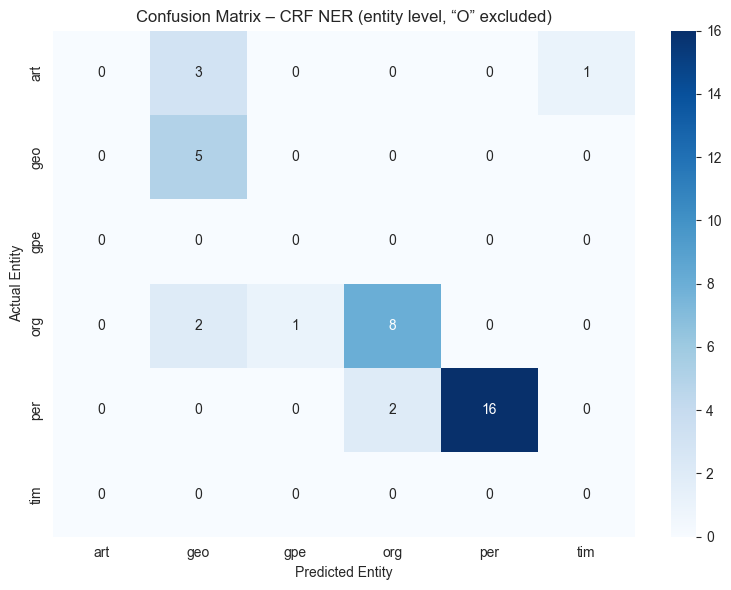

In [16]:
collapse = lambda t: t.split('-', 1)[-1] if '-' in t else t
true_ent = list(map(collapse, true_flat))
pred_ent = list(map(collapse, crf_pred_flat))

entity_labels = sorted({lab for lab in true_ent + pred_ent if lab != 'O'})

cm = confusion_matrix(true_ent, pred_ent, labels=entity_labels)

plt.figure(figsize=(8, 6))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',                
    cmap='Blues',
    xticklabels=entity_labels,
    yticklabels=entity_labels
)
plt.xlabel('Predicted Entity')
plt.ylabel('Actual Entity')
plt.title('Confusion Matrix – CRF NER (entity level, “O” excluded)')
plt.tight_layout()
plt.show()

## Transformers (BERT) for NERC

In [17]:
from simpletransformers.ner import NERModel
bert_model = NERModel(
        model_type="bert",
        model_name="dslim/bert-base-NER",
        use_cuda=False
)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Transforming the test data

In [18]:
test_data = []
for sentence in test_sentences:
    new_sentence = []
    for word in sentence:
        new_sentence.append(word[0])
        
    test_data.append(" ".join(new_sentence))

## Predicting with the BERT model

In [19]:
bert_predictions, raw_outputs = bert_model.predict(test_data)

  0%|          | 0/1 [00:00<?, ?it/s]

Running Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

## Converting the predictions to the required format

In [20]:
converted_bert_predictions = []
label_mapping = {
        'B-PER': 'B-per',
        'I-PER': 'I-per',
        'B-ORG': 'B-org', 
        'I-ORG': 'I-org',
        'B-LOC': 'B-geo',
        'I-LOC': 'I-geo',
        'B-MISC': 'B-art',
        'I-MISC': 'I-art',
        'O': 'O'
}
for sentence_prediction in bert_predictions:
    converted_sentence_prediction = []
    
    for word_prediction in sentence_prediction:
        for _, label in word_prediction.items():
            converted_sentence_prediction.append(label_mapping[label])
            
    converted_bert_predictions.append(converted_sentence_prediction)

## Evaluating the BERT model predictions

### With all labels:

In [21]:
labels = list(set([label for sublist in converted_bert_predictions for label in sublist]))
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)

print(metrics.flat_classification_report(
    y_test, converted_bert_predictions, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      0.963     0.994     0.978       159
       B-art      0.571     0.667     0.615         6
       I-art      0.857     0.750     0.800         8
       B-geo      0.750     1.000     0.857         3
       I-geo      1.000     1.000     1.000         2
       B-org      0.750     0.750     0.750         8
       I-org      0.600     0.600     0.600         5
       B-per      0.800     0.667     0.727        12
       I-per      1.000     0.692     0.818        13

    accuracy                          0.921       216
   macro avg      0.810     0.791     0.794       216
weighted avg      0.923     0.921     0.919       216


### Without 'O' label:

In [22]:
labels.remove('O')
# metrics.flat_f1_score(y_test, converted_bert_predictions, 
#                       average='weighted', labels=labels)
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, converted_bert_predictions, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

       B-art      0.571     0.667     0.615         6
       I-art      0.857     0.750     0.800         8
       B-geo      0.750     1.000     0.857         3
       I-geo      1.000     1.000     1.000         2
       B-org      0.750     0.750     0.750         8
       I-org      0.600     0.600     0.600         5
       B-per      0.800     0.667     0.727        12
       I-per      1.000     0.692     0.818        13

   micro avg      0.788     0.719     0.752        57
   macro avg      0.791     0.766     0.771        57
weighted avg      0.809     0.719     0.755        57


## Visualizing the results

### With all labels:

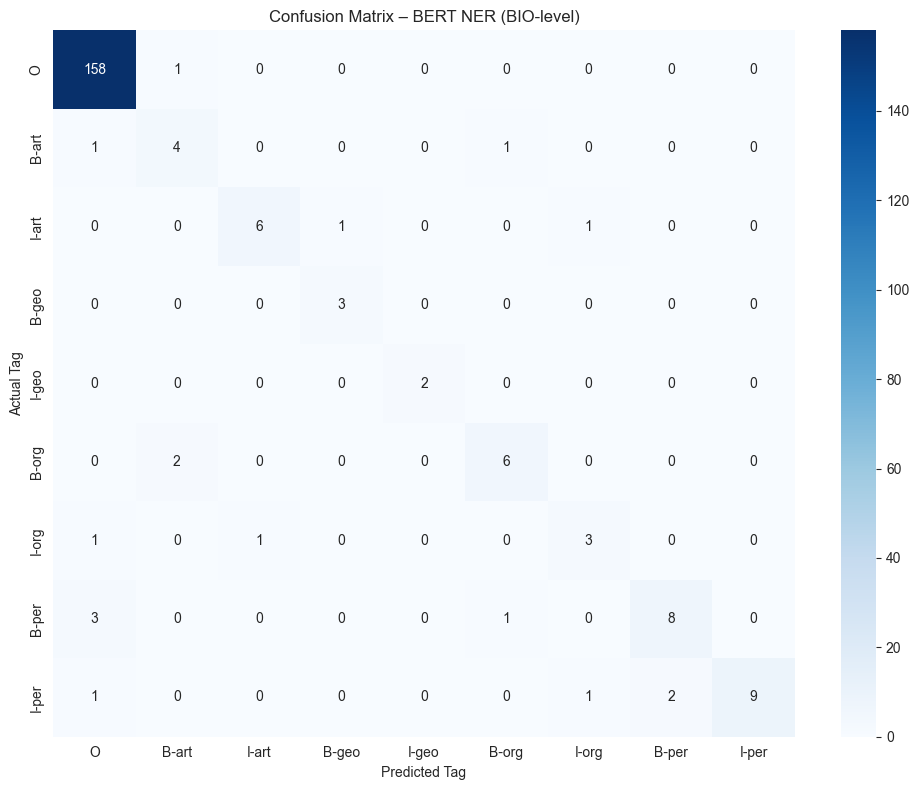

In [23]:
true_flat = []
bert_pred_flat = []
for sent in y_test:           
    for tag in sent:         
        true_flat.append(tag) 

for sent in converted_bert_predictions:  
    for tag in sent:                    
        bert_pred_flat.append(tag)           

labels_bio = sorted(set(true_flat + bert_pred_flat), key=lambda x: (x[2:], x[0]))  # e.g. B-LOC before I-LOC

cm = confusion_matrix(true_flat, bert_pred_flat, labels=labels_bio)

plt.figure(figsize=(10, 8))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels_bio,
    yticklabels=labels_bio
)
plt.xlabel('Predicted Tag')
plt.ylabel('Actual Tag')
plt.title('Confusion Matrix – BERT NER (BIO-level)')
plt.tight_layout()
plt.show()

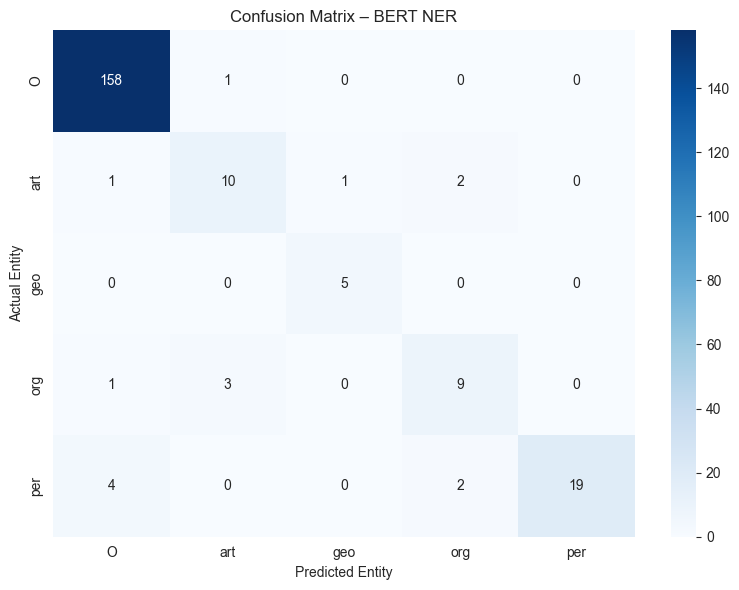

In [24]:
collapse = lambda t: t.split("-", 1)[-1] if "-" in t else t
true_ent = list(map(collapse, true_flat))
pred_ent = list(map(collapse, bert_pred_flat))

labels_simple = sorted(set(true_ent + pred_ent))

cm = confusion_matrix(true_ent, pred_ent, labels=labels_simple)

plt.figure(figsize=(8, 6))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels_simple,
    yticklabels=labels_simple
)
plt.xlabel('Predicted Entity')
plt.ylabel('Actual Entity')
plt.title('Confusion Matrix – BERT NER')
plt.tight_layout()
plt.show()

### Without O label:

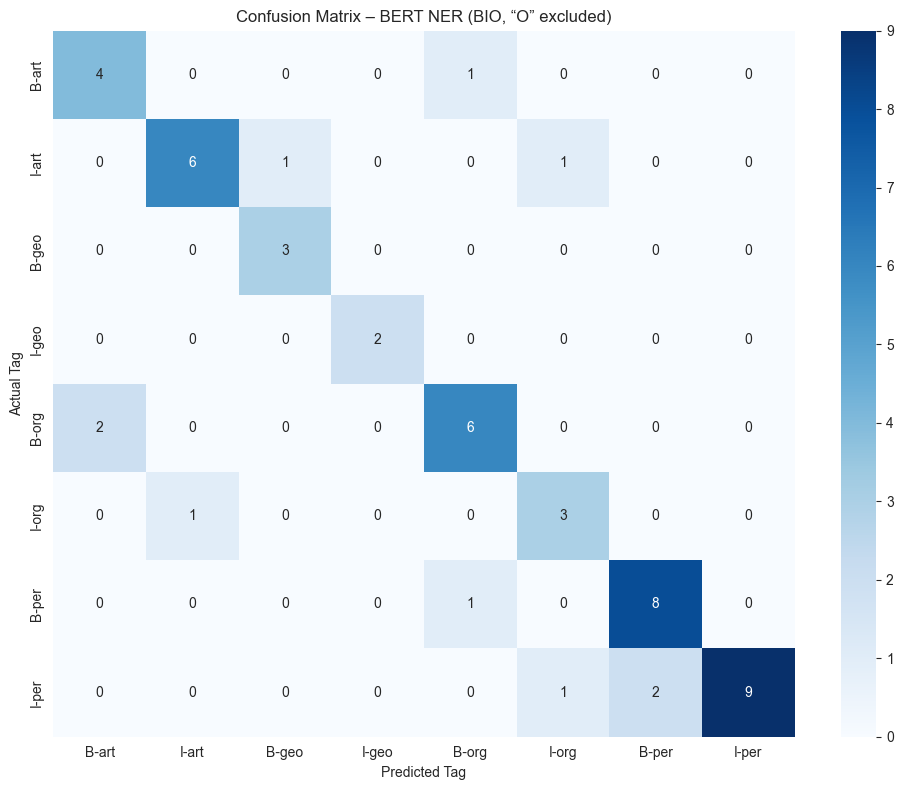

In [25]:
cm = confusion_matrix(true_flat, bert_pred_flat, labels=sorted_labels)

plt.figure(figsize=(10, 8))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',         
    cmap='Blues',
    xticklabels=sorted_labels,
    yticklabels=sorted_labels
)
plt.xlabel('Predicted Tag')
plt.ylabel('Actual Tag')
plt.title('Confusion Matrix – BERT NER (BIO, “O” excluded)')
plt.tight_layout()
plt.show()

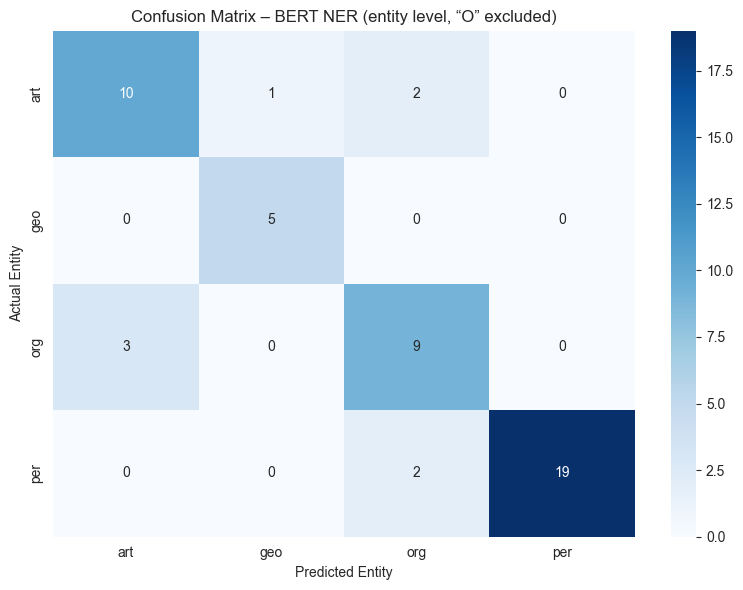

In [26]:
collapse = lambda t: t.split('-', 1)[-1] if '-' in t else t
true_ent = list(map(collapse, true_flat))
pred_ent = list(map(collapse, bert_pred_flat))

entity_labels = sorted({lab for lab in true_ent + pred_ent if lab != 'O'})

cm = confusion_matrix(true_ent, pred_ent, labels=entity_labels)

plt.figure(figsize=(8, 6))
sn.heatmap(
    cm,
    annot=True,
    fmt='d',            
    cmap='Blues',
    xticklabels=entity_labels,
    yticklabels=entity_labels
)
plt.xlabel('Predicted Entity')
plt.ylabel('Actual Entity')
plt.title('Confusion Matrix – BERT NER (entity level, “O” excluded)')
plt.tight_layout()
plt.show()


## Comparing BERT and CRF models

,token_accuracy,weighted_F1
model,,
BERT,0.921,0.974
CRF,0.838,0.923


/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bogdankryvenko/Desktop/pythonProject333/.venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


model,BERT,CRF
label,,
art,0.462,0.000
geo,0.857,0.600
org,0.706,0.286
per,0.727,0.762


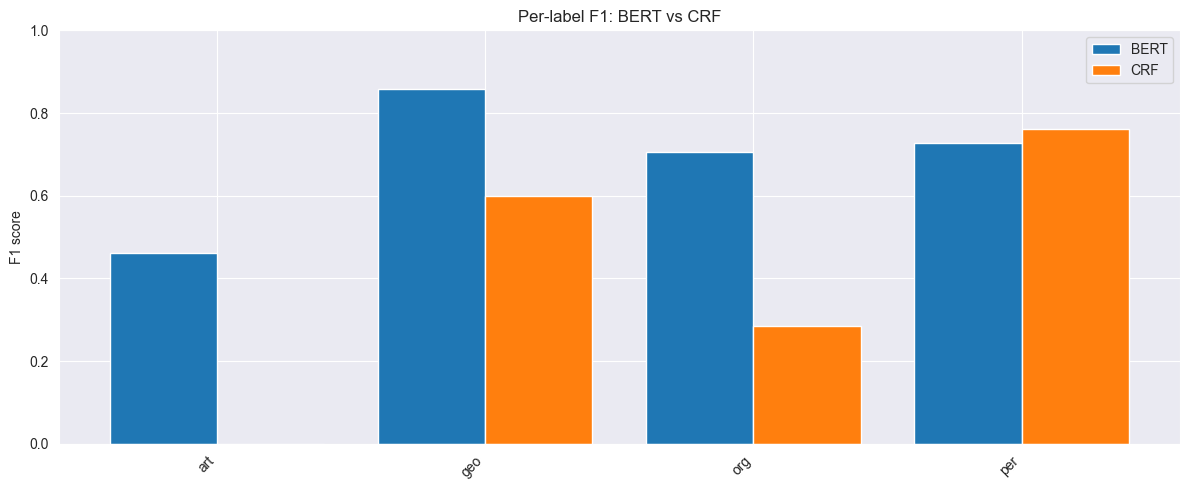

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from seqeval.metrics import classification_report

overall = {
    "model": ["BERT", "CRF"],
    "token_accuracy": [
        accuracy_score(true_flat, bert_pred_flat),
        accuracy_score(true_flat, crf_pred_flat)
    ],
    "weighted_F1": [
        metrics.flat_f1_score(y_test, converted_bert_predictions,
                              average="weighted", labels=true_flat),
        metrics.flat_f1_score(y_test, y_pred,
                              average="weighted", labels=true_flat)
    ]
}

overall_df = pd.DataFrame(overall).set_index("model")
display(overall_df.style.format("{:.3f}"))

def prf_dict(y_true, y_hat):
    report = classification_report(y_true, y_hat, output_dict=True)
    
    result = {}
    for label in report:                                  
        if label not in ("micro avg", "macro avg", "weighted avg"):
            result[label] = report[label]                   
    
    return result


bert_prf = prf_dict(y_test, converted_bert_predictions)
crf_prf  = prf_dict(y_test, y_pred)
crf_prf.pop("gpe")

rows = []

all_labels = set()
for lbl in bert_prf:        
    all_labels.add(lbl)
for lbl in crf_prf:        
    all_labels.add(lbl)

def label_sort_key(tag):
    return (tag[2:], tag[0])   

sorted_labels = sorted(all_labels, key=label_sort_key)

for label in sorted_labels:
    for model_name, report in (("BERT", bert_prf), ("CRF", crf_prf)):
        if label in report:         
            row = {
                "label"    : label,
                "model"    : model_name,
                "precision": report[label]["precision"],
                "recall"   : report[label]["recall"],
                "f1"       : report[label]["f1-score"],
                "support"  : report[label]["support"],
            }
            rows.append(row)


df_prf = pd.DataFrame(rows)

df_prf = df_prf[df_prf["label"] != "tim"]

display(df_prf.pivot(index="label", columns="model", values="f1").style.format("{:.3f}"))


plt.figure(figsize=(12, 5))
for m, offset in zip(("BERT", "CRF"), (-0.2, 0.2)):
    subset = df_prf[df_prf.model == m].sort_values("label")
    positions = range(len(subset))
    plt.bar([p + offset for p in positions], subset["f1"], width=0.4, label=m)

plt.xticks(range(len(subset)), subset["label"], rotation=45, ha="right")
plt.ylabel("F1 score")
plt.title("Per-label F1: BERT vs CRF")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
plt.show()

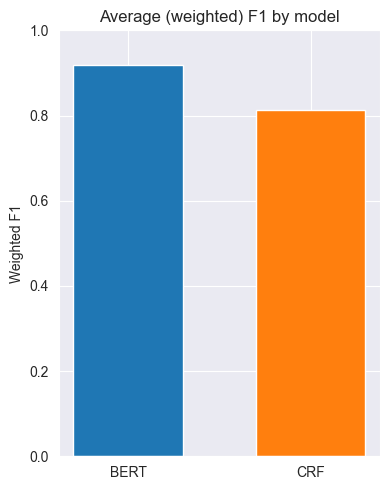

In [42]:
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {"BERT": cycle_colors[0],  
                "CRF" : cycle_colors[1]}   

order = ["BERT", "CRF"]

fig, ax = plt.subplots(figsize=(4, 5))
ax.bar(order,
       overall_df.loc[order, "weighted_F1"],
       color=[model_colors[m] for m in order],
       width=0.6)

ax.set_ylabel("Weighted F1")
ax.set_ylim(0, 1.0)
ax.set_title("Average (weighted) F1 by model")
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)         
plt.tight_layout()
plt.show()
